In [223]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

In [224]:
# Download an image and read it into a NumPy array, 
def download(url):
    name = url.split("/")[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = image.load_img(image_path,target_size = (1000,1000))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis = 0)
    return img

In [225]:
# Scale pixels to between (-1.0 and 1.0)
# def preprocess(img):
#     return (img / 127.5) - 1

In [226]:
# Undo the preprocessing above
def deprocess(img):
    img[:,:,0] += 103.939
    img[:,:,1] += 116.779
    img[:,:,2] += 123.68
    img = img[:, :, ::-1]
    img =  np.clip(img, 0, 255).astype('uint8')
    return img

In [227]:
# Display an image
def show(img):
    if(len(img.shape) == 4):
        img = np.squeeze(img, axis = 0)
    img = deprocess(img)
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.imshow(img)
    return

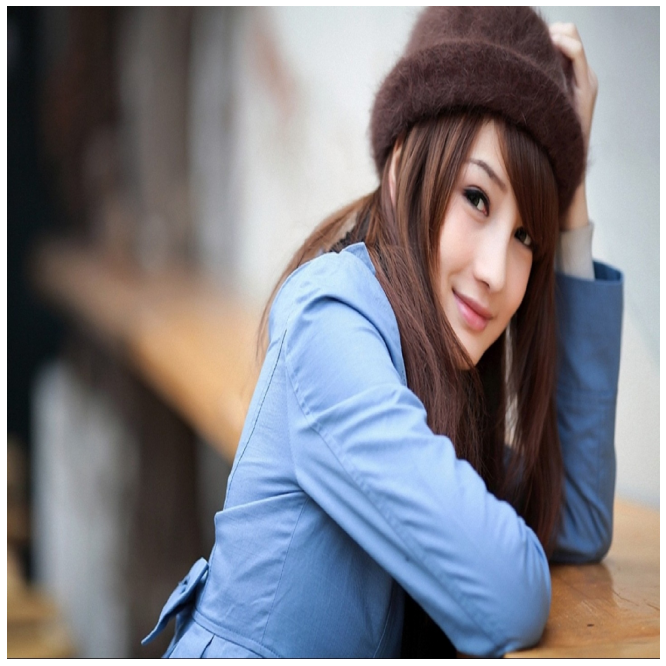

In [228]:
content_path = 'https://www.hdwallback.net/wp-content/uploads/2018/02/cute-girl-wallpaper-hd.jpg'
content_image = download(content_path)
show(content_image)

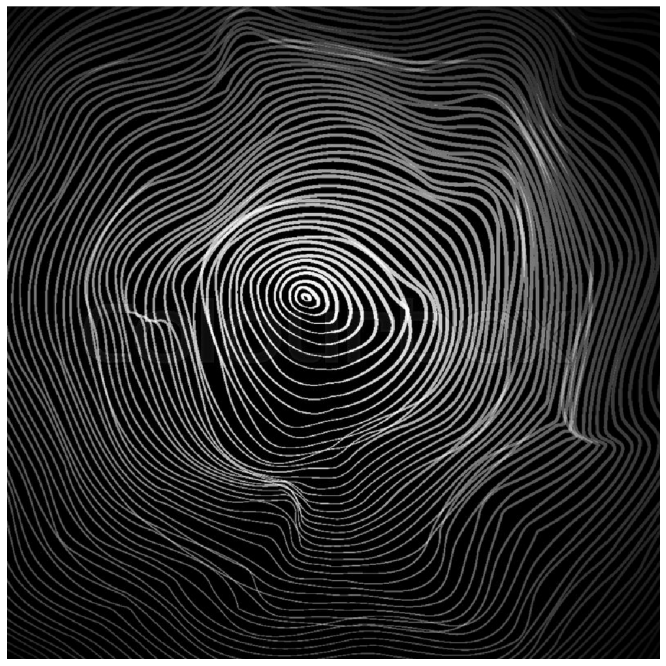

In [229]:
style_path = 'https://d2gg9evh47fn9z.cloudfront.net/800px_COLOURBOX30022748.jpg'
style_image = download(style_path)
show(style_image)

In [230]:
model = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet')
model.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" />

In [231]:
style_layers = ['block1_conv1', 'block3_conv1', 'block5_conv1']
content_layer = 'block5_conv1'

# style_layers = [model.get_layer(current_layer).output for current_layer in style_layers]
# content_layer = [model.get_layer(current_layer).output for current_layer in content_layer]

In [232]:
content_model = Model(inputs = model.input, outputs = model.get_layer(content_layer).output)
style_models = [Model(inputs = model.input, outputs = model.get_layer(current_layer).output) for current_layer in style_layers]

In [233]:
content_model.summary()

Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

In [234]:
style_models[0].summary()

Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________


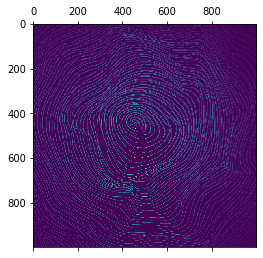

In [235]:
index = 0
a_S = style_models[index](style_image)
plt.matshow(a_S[0,:,:,12])

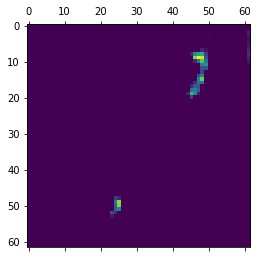

In [236]:
index = 2
a_S = style_models[index](style_image)
plt.matshow(a_S[0,:,:,12])

In [237]:
def content_cost(content, generated):
    a_C = content_model(content)
    a_G = content_model(generated)
    cost = tf.reduce_mean(tf.square(a_C - a_G))
    return cost

In [238]:
def gram_matrix(A):
    channel = A.shape[-1]
    A = tf.reshape(A, (-1, channel))
    n = tf.shape(A)[0]
    gram = tf.matmul(A,A, transpose_a = True)
    return gram/tf.cast(n, tf.float32)

In [239]:
lam = 1/len(style_models)
def style_cost(style, generated):
    J_style = 0
    current_cost = []
    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        G_s = gram_matrix(a_S)
        G_g = gram_matrix(a_G)
        current_cost.append(tf.reduce_mean(tf.square(G_s - G_g)))
    J_style = (4/6)*current_cost[0] + (1/6)*current_cost[1] + (1/6)*current_cost[2]
    return J_style

In [240]:
generated_images = []
def trainig_loop(content_path, style_path, iterations, alpha, beta, lr_rate):
    content = download(content_path)
    style = download(style_path)
    generated = tf.Variable(content)
    
    opt = tf.optimizers.Adam(learning_rate = lr_rate)
    J_min = 1e12 + 0.1
    for i in range(iterations):
        with tf.GradientTape(persistent = True) as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_cost = alpha*J_content + beta*J_style
        
        grads = tape.gradient(J_cost, generated)
        opt.apply_gradients([(grads, generated)])
        if J_cost < J_min:
            J_min = J_cost
            best_pic = generated.numpy()
        if i%5 == 0:
          print('cost at iteration ' + str(i) + ' = ' + str(J_cost.numpy()))
          generated_images.append(generated.numpy())
    return best_pic

In [241]:
itr = 150
alpha = 10
beta = 90
lr_rate = 8

final = trainig_loop(content_path,style_path,itr,alpha, beta, lr_rate)

cost at iteration 0 = 742373300000.0
cost at iteration 5 = 255670700000.0
cost at iteration 10 = 148550800000.0
cost at iteration 15 = 100495780000.0
cost at iteration 20 = 73058296000.0
cost at iteration 25 = 54448700000.0
cost at iteration 30 = 42366720000.0
cost at iteration 35 = 33926920000.0
cost at iteration 40 = 27800430000.0
cost at iteration 45 = 23156902000.0
cost at iteration 50 = 19568191000.0
cost at iteration 55 = 16768148000.0
cost at iteration 60 = 14547387000.0
cost at iteration 65 = 12751795000.0
cost at iteration 70 = 11277624000.0
cost at iteration 75 = 10053434000.0
cost at iteration 80 = 9027252000.0
cost at iteration 85 = 8158845400.0
cost at iteration 90 = 7415342000.0
cost at iteration 95 = 6772859000.0
cost at iteration 100 = 6211014700.0
cost at iteration 105 = 5717548500.0
cost at iteration 110 = 5280283600.0
cost at iteration 115 = 4890331000.0
cost at iteration 120 = 4542900000.0
cost at iteration 125 = 4231696000.0
cost at iteration 130 = 3951955000.0
cos

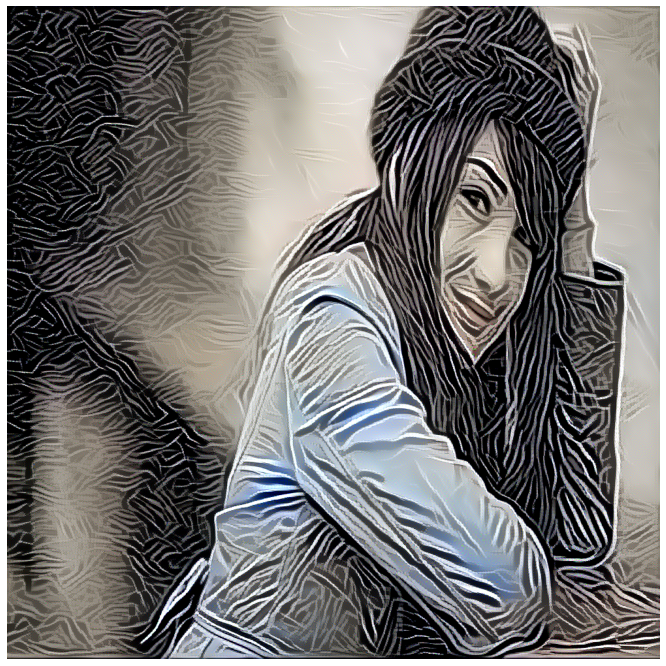

In [242]:
show(final)